# Maps in BARK

This notebook provides a short introduction to the map-format used in BARK.
First, we will go into detail of the OpenDrive format, then we will give an overview how to import and analyze the maps and, finally, how to efficiently use them within BARK.

BARK, therefore, extends the OpenDrive format using Road- and Lane-Corridors.
These are routing based road and lane abstractions that provide an easy-to-use interface for any agent/planner.



## OpenDrive Format

We outline the most important aspects of the OpenDrive format here.
Each map-file is represented in a XML-format in which roads, junctions and lanes are defined.
As BARK does not support signals (e.g. traffic lights), these are omitted in the following discussion.

Each road in the OpenDrive format has a PlanView that provides a geometric definition of the road.
```xml
<planView>
   <geometry s="0" x="0" y="0" hdg="1.5707963267987366e+00" length="100">
      <line/>
   </geometry>
</planView>
```
The geometries within the PlanView can be lines, arcs or spirals.

And each road has LaneSections that define a certain length of the road.
Within a lane section the number of lanes is constant.
Thus, by using LaneSections it is possible to change the number of lanes in a single lane.
A LaneSection has one or multiple lanes that are derived from the PlanViews geometry and then iteratively from the inner lane's geometry.
```xml
<laneSection s="0.0000000000000000e+00">
   <lane id="3" type="sidewalk" level= "false">
      <link>
         <predecessor id="-1"/>
         <successor id="-1"/>
      </link>
      <width sOffset="0" a="1.5" b="0" c="0" d=-0"/>
   </lane>
</laneSection>
```

Each lane and road can have predecessors and successors defined.
Additionally, for more complex linking, such as intersections junctions can be used.
Junctions are defined as
```xml
<junction name="" id="2">
   <connection id="0" incomingRoad="8" connectingRoad="4" contactPoint="start">
      <laneLink from="1" to="-1"/>
      <laneLink from="2" to="-2"/>
      <laneLink from="3" to="-3"/>
   </connection>
</junction>
```
having lane-links and connections for the roads.

BARK initially stores the map in exactly the same structure as the OpenDrive format in c++.
These c++ files can be found in the folder `modules/world/opendrive/':

```
BUILD                   junction.hpp            lane_section.cpp        odrSpiral.hpp           plan_view.hpp
commons.hpp             lane.cpp                lane_section.hpp        opendrive.hpp           road.cpp
helpers.hpp             lane.hpp                odrSpiral.cpp           plan_view.cpp           road.hpp
```

For a more detailed specification visit the OpenDrive website at http://www.opendrive.org.

## BARK-specific Maps

Additionally to the OpenDrive structure BARK creates a *RoadGraph*, that includes all lanes and their connections. The RoadGraph, therefore, provides an abstraction layer and easy-to-use interface to query the OpenDrive format -- e.g. it can be used for routing. The implementation of the RoadGraph can be found in `modules/world/map/roadgraph.hpp'.

The *MapInterface* implements functions, such as a routing function and other utility functions.
It also generates routing specific RoadCorridors and LaneCorridors.
Each agent in BARK has at least one RoadCorridor that it is following.

The *RoadCorridor* can be seen as a route specific OpenDrive road that the agent is following.
Each agent can act within its RoadCorridor, such as following the lane or changing the lanes within it.
The agent can e.g. query the RoadCorridor on which lane it currently is and if there are neighboring lanes that it can change to.

A RoadCorridor has additonally *LaneCorridors*. These are consecutive concatenated lanes within the RoadCorridor that provide additonal utility functions.

All these definitions can be found within the `modules/world/map/' folder.

## Importing an OpenDrive Map

In the folowing, we will load the example intersection map provided on the OpenDrive website.
Therefore, we use the *XodrParser* of BARK.
The XodrParser parses the OpenDrive xml-file and converts it to the c++ OpenDrive structure.

In [13]:
import bark
from modules.runtime.commons.xodr_parser import XodrParser
xodr_parser = XodrParser("../../modules/runtime/tests/data/Crossing8Course.xodr")


## MapInterface
In this step, we create the MapInterface that provides an easy-to-use interface for the OpenDrive structure.
As above-mentioned, the MapInterface provides a wide range of ulitity- and handling functions for the map.


In [14]:
from modules.runtime.commons.parameters import ParameterServer
from bark.world import World
from bark.world.map import MapInterface

params = ParameterServer()
world = World(params)
# create the MapInterface using the parsed OpenDrive file
map_interface = MapInterface()
map_interface.SetOpenDriveMap(xodr_parser.map)
world.SetMap(map_interface)

# to access the original OpenDrive map
open_drive_map = world.map.GetOpenDriveMap()

As a next step, we now can visualize the parsed map and ensure it has been created properly.

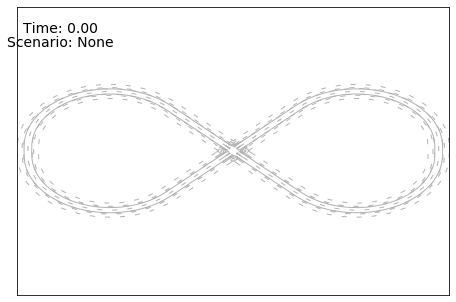

<Figure size 432x288 with 0 Axes>

In [30]:
from modules.runtime.viewer.matplotlib_viewer import MPViewer
import matplotlib.pyplot as plt
viewer = MPViewer(params=params,
                  use_world_bounds=True)
viewer.drawWorld(world)
viewer.show()
# viewer.clear()

The entire OpenDrive structure can also be plotted iteratively:

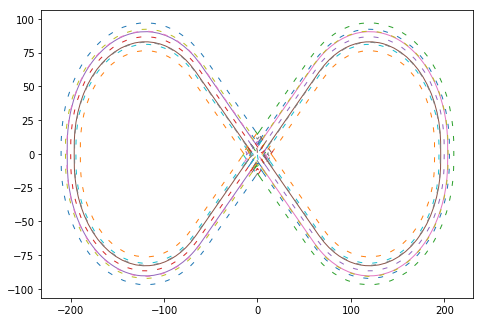

In [35]:
viewer = MPViewer(params=params,
                  use_world_bounds=True)
for idx_r, road in open_drive_map.GetRoads().items():
    for idx_ls, lane_section in enumerate(road.lane_sections):
        for idx_l, lane in lane_section.GetLanes().items():
            viewer.drawXodrLane(lane)
viewer.show()
viewer.clear()


The RoadGraph can be used for querying the OpenDrive structure:

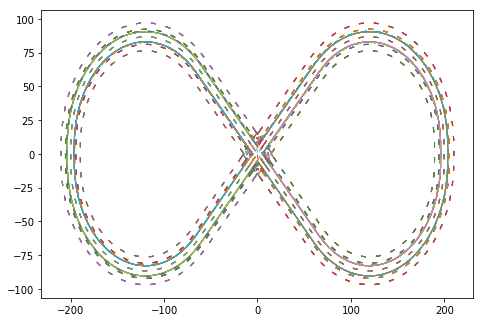

In [36]:
viewer = MPViewer(params=params,
                  use_world_bounds=True)
roadgraph = map_interface.GetRoadgraph()
# output the graph in dot-file
# roadgraph.PrintGraph(output_dir + "/" + map_name)
lane_ids = roadgraph.GetAllLaneids()

for lane_id in lane_ids:
    lane_polygon = roadgraph.GetLanePolygonForLaneId(lane_id)
    road_id = roadgraph.GetRoadForLaneId(lane_id)
    road = map_interface.GetOpenDriveMap().GetRoad(road_id)
    plan_view_reference = road.plan_view.GetReferenceLine()
    viewer.drawXodrRoad(road)
viewer.show()
viewer.clear()

A RoadCorridor can be computed by:

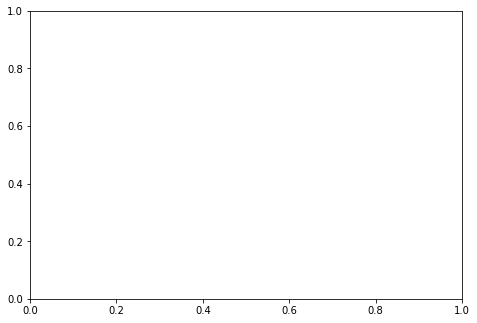

In [37]:
from bark.world.opendrive import *
viewer = MPViewer(params=params,
                  use_world_bounds=True)
# road_corridor = map_interface.GenerateRoadCorridor(self._road_ids, XodrDrivingDirection.forward)
# viewer.drawDrivingCorridor(road_corridor)

# map through LaneCorridors
viewer.show()
viewer.clear()
